In [1]:
import os
main_dir = os.path.dirname(os.path.dirname(os.getcwd()))
os.chdir(main_dir)

import pyvdirs.dirs as dirs
import sys
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

In [494]:
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

import ours.utils as utils
from ours.selection import infer_selection_params

## Parameters

In [500]:
series = ["Baseline", "Early AJEST", "AJEST", "Random"]
series_path = {"Baseline": os.path.join(dirs.MODELS_HOME, "Images", "04_Tiny_LR", "Baseline", "04"),
               "Early AJEST": os.path.join(dirs.MODELS_HOME, "Images", "06_CorrectEMA", "Early_AJEST", "00"),
               "AJEST": os.path.join(dirs.MODELS_HOME, "Images", "06_CorrectEMA", "AJEST", "00"),
               "Random": os.path.join(dirs.MODELS_HOME, "Images", "06_CorrectEMA", "Random", "00")}

plt_kwargs = dict(color = ["C0", "C3", "C4", "C1"],
                  alpha = [0.5, 0.8, 0.7, 0.6],
                  linewidth = [4, 1, 0.5, 0.5],
                  zorder=[1000,10000,100,10])
plt_kwargs_zoom = dict(color = plt_kwargs["color"],
                       alpha = [0.6, 0.8, 0.7, 0.6],
                       linewidth = [3, 1, 1, 1],
                       zorder = plt_kwargs["zorder"])
plt_kwargs_val = dict(color = plt_kwargs["color"],
                      alpha = plt_kwargs_zoom["alpha"],
                      linewidth = [3, 2, 2, 2],
                      zorder = plt_kwargs["zorder"])
plt_kwargs = {s:{k:v[i] for k,v in plt_kwargs.items()} for i,s in enumerate(series)}
plt_kwargs_zoom = {s:{k:v[i] for k,v in plt_kwargs_zoom.items()} for i,s in enumerate(series)}
plt_kwargs_val = {s:{k:v[i] for k,v in plt_kwargs_val.items()} for i,s in enumerate(series)}

In [ ]:
metrics = ["fid", "fd", "top1", "top5"]
metrics_names = {"fid":"FID", "fd":"FD-DINOv2", "top1":"Swin-L Top-1 Accuracy", "top5":"Swin-L Top-5 Accuracy"}
metrics_filename = {"fid":"FID", "fd":"FD", "top1":"Top1", "top5":"Top5"}

dir_results = os.path.join(dirs.RESULTS_HOME, "Images", "04_Main_Results")

def get_validation_filepath(metric, ema, guidance_weight=1, dir_results=dir_results):    
    if guidance_weight != 1:
        guidance_string = f"_G_{guidance_weight:.1f}"
    else:
        guidance_string = ""
    filename = "Val_"+metrics_filename[metric]+f"_{ema:.2f}"+guidance_string+"_vs_Epoch"
    return os.path.join(dir_results, filename+".csv")

def get_validation_y_label(metric, ema, guidance_weight=1):
    if guidance_weight == 1:
        conditions = f"[EMA={ema:.03f}]"
    else:
        conditions = f"[EMA={ema:.03f}, Guidance={guidance_weight:.2f}]"
    return metrics_filename[metric] + conditions

In [5]:
def load_validation_curves_set(metric, ema, guidance_weight=1, 
                               dir_results=dir_results, results_dict=None):
    
    # Load CSV data as Pandas dataframe
    filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight, dir_results=dir_results)
    pandas_data = pd.read_csv(filepath)

    # Filter columns
    for c in pandas_data.columns:
        condition = any([st in c for st in ["MIN", "MAX", "step"]])
        if condition: del pandas_data[c]
    
    # Rename columns
    if guidance_weight == 1:
        conditions = f"[EMA={ema:.03f}]"
    else:
        conditions = f"[EMA={ema:.03f}, Guidance={guidance_weight:.2f}]"
    pandas_data = pandas_data.rename(columns={f"Group: 06_CorrectEMA_AJEST_00 - Validation {metrics_names[metric]} "+conditions:"AJEST",
                                              f"Group: 06_CorrectEMA_Early_AJEST_00 - Validation {metrics_names[metric]} "+conditions:"Early AJEST",
                                              f"Group: 06_CorrectEMA_Random_00 - Validation {metrics_names[metric]} "+conditions:"Random",
                                              f"Group: 04_Tiny_LR_Baseline_04 - Validation {metrics_names[metric]} "+conditions:"Baseline",
                                              f"Group: 04_Tiny_LR_Ref_00 - Validation {metrics_names[metric]} "+conditions:"Reference",
                                              "Validation Epoch":"Epoch"})
    
    # Export into a dictionary with Numpy arrays
    ema_string = f"ema={ema:.3f}"
    guidance_string = f"guidance={guidance_weight:.2f}"
    if results_dict is None:
        results_dict = {}
    try: results_dict[metric]
    except: results_dict[metric] = {}
    try: results_dict[metric][ema_string]
    except: results_dict[metric][ema_string] = {}
    results_dict[metric][ema_string][guidance_string] = {}
    results = results_dict[metric][ema_string][guidance_string]
    for s in series:
        results[s] = {}
        results[s]["epoch"], results[s]["data"] = pandas_data[["Epoch",s]][pd.notna(pandas_data[s])].to_numpy().T

    return results_dict

In [6]:
results = {} # Training
results_val = {} # Validation
for k in metrics: results_val[k] = {}

In [7]:
regex_series = {
    "Baseline": 'Epoch|Baseline.*]',
    "AJEST": "Epoch|EMA_AJEST.*]",
    "Early AJEST": "Epoch|Early_AJEST.*]",
    "Random": 'Epoch|Random.*]',
}

In [502]:
series_selection_kwargs = {}
for s in series:

    state = utils.get_final_state(series_path[s])
    state_selection_keys = ["change_epoch", "change_nimg"]
    selection_kwargs = {k:state[k] for k in state_selection_keys}

    params = utils.get_training_params(series_path[s])
    selection_params = infer_selection_params(params)
    selection_kwargs.update( selection_params )
    
    series_selection_kwargs[s] = selection_kwargs

# W&B Training Plots' Data

## Parameters

In [8]:
dir_results = os.path.join(dirs.RESULTS_HOME, "Images", "04_Main_Results")

In [9]:
series = ["Baseline", "Early AJEST", "AJEST", "Random"]
plt_kwargs = dict(color = ["C0", "C3", "C4", "C1"],
                  alpha = [0.5, 0.8, 0.7, 0.6],
                  linewidth = [4, 1, 0.5, 0.5],
                  zorder=[1000,10000,100,10])
plt_kwargs_zoom = dict(color = ["C0", "C3", "C4", "C1"],
                       alpha = [0.6, 0.8, 0.7, 0.6],
                       linewidth = [3, 1, 1, 1],
                       zorder=[1000,10000,100,10])
plt_kwargs = {s:{k:v[i] for k,v in plt_kwargs.items()} for i,s in enumerate(series)}
plt_kwargs_zoom = {s:{k:v[i] for k,v in plt_kwargs_zoom.items()} for i,s in enumerate(series)}

In [10]:
results = {}

## Time

### Load data into Pandas

In [11]:
pandas_data = pd.read_csv(os.path.join(dir_results, "Main_Results_Loss_vs_Time.csv"))

In [12]:
pandas_data

,Training Time [sec],Training time [hs],Group: 06_CorrectEMA_AJEST_00 - Loss,Group: 06_CorrectEMA_Early_AJEST_00 - Loss,Group: 06_CorrectEMA_Random_00 - Loss,Group: 04_Tiny_LR_Baseline_04 - Loss,Group: 04_Tiny_LR_Ref_00 - Loss
0,1.055769e+04,0.002933,NaN,NaN,20.138007,NaN,NaN
1,1.129142e+04,0.003137,NaN,NaN,NaN,NaN,15.073979
2,1.143390e+04,0.003176,NaN,NaN,NaN,NaN,15.128112
3,1.543995e+04,0.004289,38.754126,NaN,NaN,NaN,NaN
4,1.671881e+04,0.004644,NaN,NaN,NaN,NaN,14.986211
...,...,...,...,...,...,...,...
65467,1.727988e+08,47.999678,NaN,-9.626287,NaN,NaN,NaN
65468,1.728010e+08,48.000283,NaN,NaN,NaN,-10.320302,NaN
65469,1.728093e+08,48.002574,NaN,NaN,-8.109115,NaN,NaN
65470,1.728143e+08,48.003983,NaN,-10.160560,NaN,NaN,NaN


### Preprocess with Pandas

In [13]:
pandas_data = pandas_data.rename(columns={"Group: 06_CorrectEMA_AJEST_00 - Loss":"AJEST",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Loss":"Early AJEST",
                                          "Group: 06_CorrectEMA_Random_00 - Loss":"Random",
                                          "Group: 04_Tiny_LR_Baseline_04 - Loss":"Baseline",
                                          "Group: 04_Tiny_LR_Ref_00 - Loss":"Reference"})

### Get data in Numpy

In [14]:
results["time"] = {}
for s in series:
    results["time"][s] = {}
    results["time"][s]["time"], results["time"][s]["loss"] = pandas_data[["Training time [hs]",s]][pd.notna(pandas_data[s])].to_numpy().T

### Plot

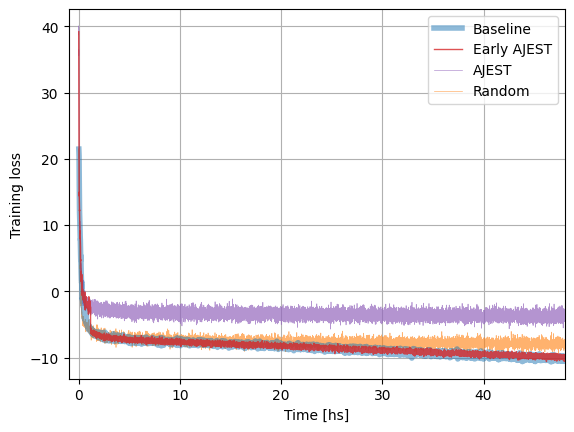

In [15]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["time"][s]["time"], results["time"][s]["loss"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Time [hs]")
plt.ylabel("Training loss")
plt.xlim([-1, 48])
plt.grid()

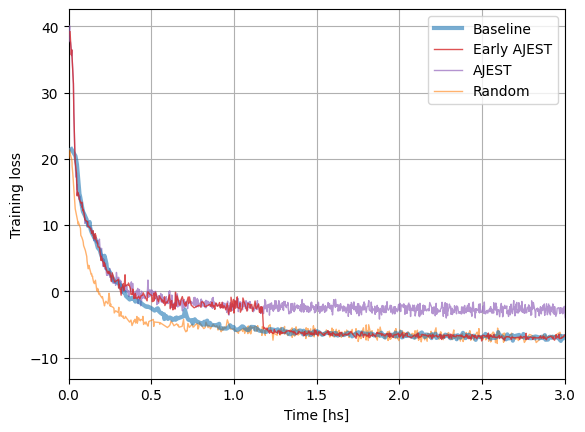

In [16]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["time"][s]["time"], results["time"][s]["loss"], label=s, **plt_kwargs_zoom[s])
plt.legend()
plt.xlabel("Time [hs]")
plt.ylabel("Training loss")
# plt.xlim([-1, 48])
plt.xlim([0, 3])
plt.grid()

## Epoch

### Load data into Pandas

In [17]:
pandas_data = pd.read_csv(os.path.join(dir_results, "Main_Results_Loss_vs_Epoch.csv"))

In [18]:
pandas_data

,Epoch,Group: 06_CorrectEMA_AJEST_00 - _step,Group: 06_CorrectEMA_AJEST_00 - _step__MIN,Group: 06_CorrectEMA_AJEST_00 - _step__MAX,Group: 06_CorrectEMA_AJEST_00 - Loss,Group: 06_CorrectEMA_AJEST_00 - Loss__MIN,Group: 06_CorrectEMA_AJEST_00 - Loss__MAX,Group: 06_CorrectEMA_Early_AJEST_00 - _step,Group: 06_CorrectEMA_Early_AJEST_00 - _step__MIN,Group: 06_CorrectEMA_Early_AJEST_00 - _step__MAX,...,Group: 04_Tiny_LR_Baseline_04 - _step__MAX,Group: 04_Tiny_LR_Baseline_04 - Loss,Group: 04_Tiny_LR_Baseline_04 - Loss__MIN,Group: 04_Tiny_LR_Baseline_04 - Loss__MAX,Group: 04_Tiny_LR_Ref_00 - _step,Group: 04_Tiny_LR_Ref_00 - _step__MIN,Group: 04_Tiny_LR_Ref_00 - _step__MAX,Group: 04_Tiny_LR_Ref_00 - Loss,Group: 04_Tiny_LR_Ref_00 - Loss__MIN,Group: 04_Tiny_LR_Ref_00 - Loss__MAX
0,0,8.0,8.0,8.0,38.377435,38.000744,38.754126,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,14.962896,14.838368,15.087425
1,1,18.0,18.0,18.0,38.953883,37.824091,40.083675,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,27.0,27.0,27.0,...,27.0,21.979856,21.979856,21.979856,NaN,NaN,NaN,NaN,NaN,NaN
3,3,36.0,36.0,36.0,37.956989,37.645382,38.268596,NaN,NaN,NaN,...,36.0,21.414513,21.414513,21.414513,19.0,19.0,19.0,14.950516,14.914821,14.986211
4,4,45.0,45.0,45.0,36.624354,35.902883,37.345825,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44519,81805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,743954.0,-14.074966,-14.074966,-14.074966,NaN,NaN,NaN,NaN,NaN,NaN
44520,81809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,743790.0,-13.611989,-13.611989,-13.611989,NaN,NaN,NaN,NaN,NaN,NaN
44521,81810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,743799.0,-13.942100,-13.942100,-13.942100,NaN,NaN,NaN,NaN,NaN,NaN
44522,81827,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,744152.0,-13.696459,-13.696459,-13.696459,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess with Pandas

In [19]:
for c in pandas_data.columns:
    condition = any([st in c for st in ["MIN", "MAX", "step"]])
    if condition: del pandas_data[c]

In [20]:
pandas_data = pandas_data.rename(columns={"Group: 06_CorrectEMA_AJEST_00 - Loss":"AJEST",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Loss":"Early AJEST",
                                          "Group: 06_CorrectEMA_Random_00 - Loss":"Random",
                                          "Group: 04_Tiny_LR_Baseline_04 - Loss":"Baseline",
                                          "Group: 04_Tiny_LR_Ref_00 - Loss":"Reference"})

### Get data in Numpy

In [21]:
results["epoch"] = {}
for s in series:
    results["epoch"][s] = {}
    results["epoch"][s]["epoch"], results["epoch"][s]["loss"] = pandas_data[["Epoch",s]][pd.notna(pandas_data[s])].to_numpy().T

### Plot

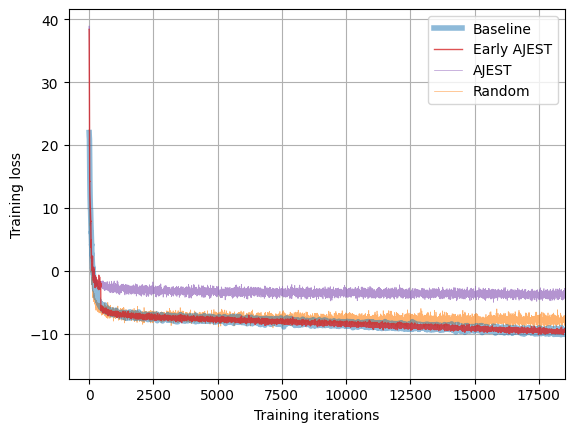

In [22]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["epoch"][s]["epoch"], results["epoch"][s]["loss"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel("Training loss")
plt.xlim([-800, 18500])
plt.grid()

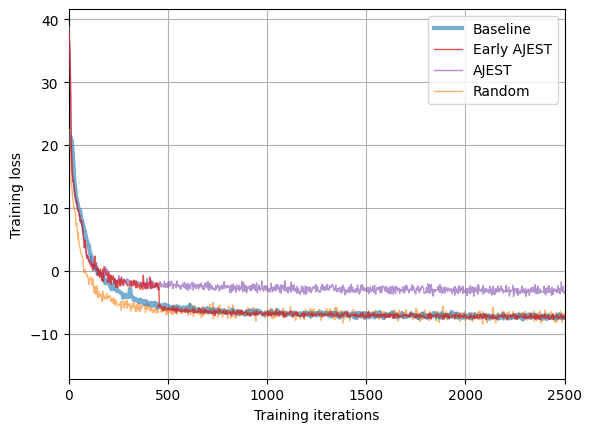

In [23]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["epoch"][s]["epoch"], results["epoch"][s]["loss"], label=s, **plt_kwargs_zoom[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel("Training loss")
plt.xlim([0, 2500])
plt.grid()

## Images seen

### Load data into Pandas

In [24]:
pandas_data = pd.read_csv(os.path.join(dir_results, "Main_Results_Loss_vs_Seen_Images.csv"))

In [25]:
pandas_data

,Seen images [kimg],Group: 06_CorrectEMA_AJEST_00 - _step,Group: 06_CorrectEMA_AJEST_00 - _step__MIN,Group: 06_CorrectEMA_AJEST_00 - _step__MAX,Group: 06_CorrectEMA_AJEST_00 - Loss,Group: 06_CorrectEMA_AJEST_00 - Loss__MIN,Group: 06_CorrectEMA_AJEST_00 - Loss__MAX,Group: 06_CorrectEMA_Early_AJEST_00 - _step,Group: 06_CorrectEMA_Early_AJEST_00 - _step__MIN,Group: 06_CorrectEMA_Early_AJEST_00 - _step__MAX,...,Group: 04_Tiny_LR_Baseline_04 - _step__MAX,Group: 04_Tiny_LR_Baseline_04 - Loss,Group: 04_Tiny_LR_Baseline_04 - Loss__MIN,Group: 04_Tiny_LR_Baseline_04 - Loss__MAX,Group: 04_Tiny_LR_Ref_00 - _step,Group: 04_Tiny_LR_Ref_00 - _step__MIN,Group: 04_Tiny_LR_Ref_00 - _step__MAX,Group: 04_Tiny_LR_Ref_00 - Loss,Group: 04_Tiny_LR_Ref_00 - Loss__MIN,Group: 04_Tiny_LR_Ref_00 - Loss__MAX
0,0.384,8.0,8.0,8.0,38.000744,38.000744,38.000744,8.0,8.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.768,18.0,18.0,18.0,37.824091,37.824091,37.824091,18.0,18.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.536,36.0,36.0,36.0,37.956989,37.645382,38.268596,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.920,45.0,45.0,45.0,35.902883,35.902883,35.902883,45.0,45.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73392,167596.032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,743988.0,-13.560675,-13.560675,-13.560675,NaN,NaN,NaN,NaN,NaN,NaN
73393,167600.128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,744006.0,-13.906603,-13.906603,-13.906603,NaN,NaN,NaN,NaN,NaN,NaN
73394,167604.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,744024.0,-13.662324,-13.662324,-13.662324,NaN,NaN,NaN,NaN,NaN,NaN
73395,167608.320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,744242.0,-14.272428,-14.272428,-14.272428,NaN,NaN,NaN,NaN,NaN,NaN


### Preprocess with Pandas

In [26]:
for c in pandas_data.columns:
    condition = any([st in c for st in ["MIN", "MAX", "step"]])
    if condition: del pandas_data[c]

In [27]:
pandas_data = pandas_data.rename(columns={"Group: 06_CorrectEMA_AJEST_00 - Loss":"AJEST",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Loss":"Early AJEST",
                                          "Group: 06_CorrectEMA_Random_00 - Loss":"Random",
                                          "Group: 04_Tiny_LR_Baseline_04 - Loss":"Baseline",
                                          "Group: 04_Tiny_LR_Ref_00 - Loss":"Reference"})

### Get data in Numpy

In [28]:
results["nimg"] = {}
for s in series:
    results["nimg"][s] = {}
    results["nimg"][s]["nimg"], results["nimg"][s]["loss"] = pandas_data[["Seen images [kimg]",s]][pd.notna(pandas_data[s])].to_numpy().T

### Plot

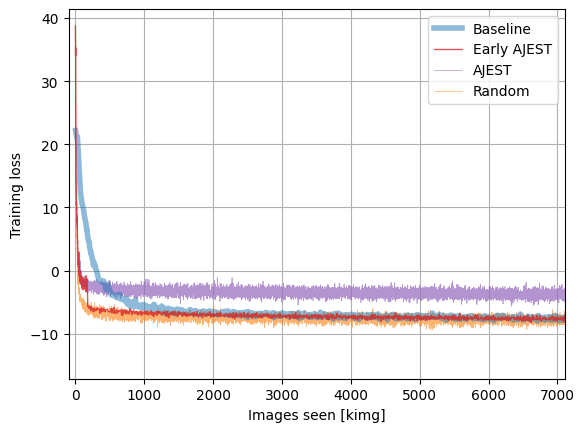

In [29]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Images seen [kimg]")
plt.ylabel("Training loss")
plt.xlim([-100, 7104])
plt.grid()

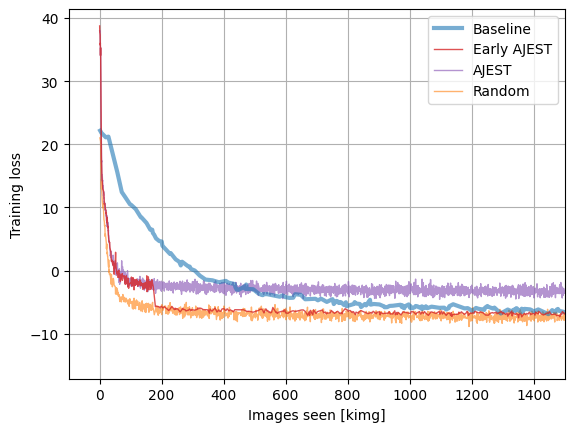

In [30]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], label=s, **plt_kwargs_zoom[s])
plt.legend()
plt.xlabel("Images seen [kimg]")
plt.ylabel("Training loss")
plt.xlim([-100, 1500])
plt.grid()

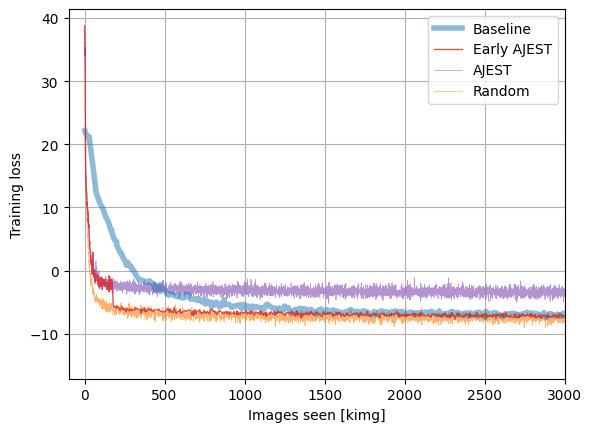

In [31]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Images seen [kimg]")
plt.ylabel("Training loss")
plt.xlim([-100, 3000])
plt.grid()

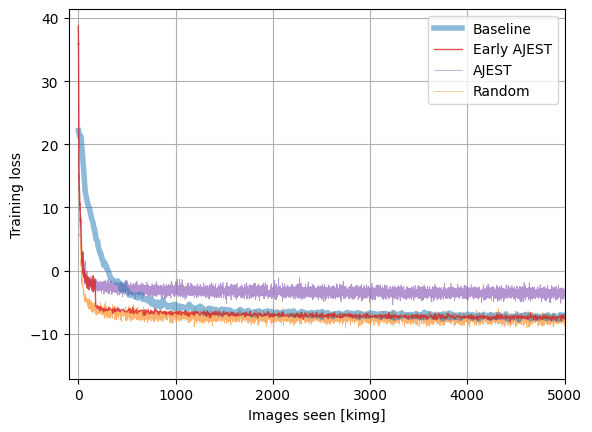

In [32]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Images seen [kimg]")
plt.ylabel("Training loss")
plt.xlim([-100, 5000])
plt.grid()

## All of those

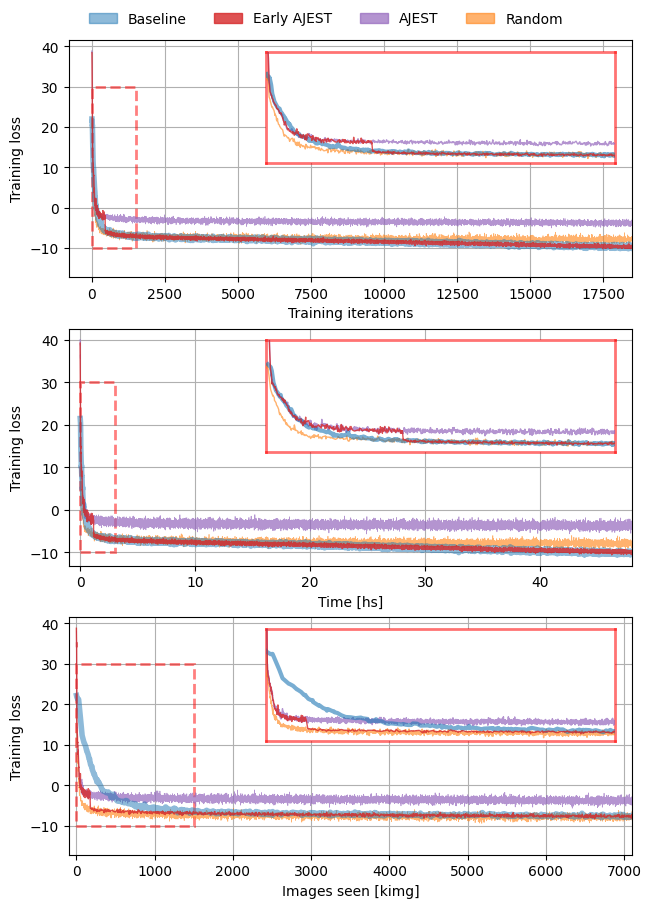

In [33]:
fig, axes = plt.subplots(nrows = 3, layout="constrained")
fig.set_size_inches([6.4, 9])
axes_in = []

# Epoch
ax = axes[0]
for s in series:
    ax.plot(results["epoch"][s]["epoch"], results["epoch"][s]["loss"], **plt_kwargs[s])
ax.set_xlabel("Training iterations")
ax.set_ylabel("Training loss")
ax.set_xlim([-800, 18500])
ax.grid()

# x1, x2, y1, y2 = [0, 2500, *ax.get_ylim()]  # subregion of the original image
x1, x2, y1, y2 = 0, 1500, -10, 30  # subregion of the original image
axin = ax.inset_axes([0.35, 0.48, 0.62, 0.47], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
legend_lines = []
for s in series:
    l, = axin.plot(results["epoch"][s]["epoch"], results["epoch"][s]["loss"], label=s, **plt_kwargs_zoom[s])
    legend_lines.append(l)
axin.set_xticks([]); axin.set_yticks([])
plt.setp(axin.spines.values(), color="red", linewidth=2, alpha=0.55)
axes_in.append(axin)
inset_indicator = ax.indicate_inset_zoom(axin, edgecolor="red", linewidth=2, zorder=5, linestyle="dashed")
for connector in inset_indicator.connectors: connector.set_visible(False)

# Time
ax = axes[1]
for s in series:
    ax.plot(results["time"][s]["time"], results["time"][s]["loss"], **plt_kwargs[s])
ax.set_xlabel("Time [hs]")
ax.set_ylabel("Training loss")
ax.set_xlim([-1, 48])
ax.grid()

# x1, x2, y1, y2 = [0, 2500, *ax.get_ylim()]  # subregion of the original image
x1, x2, y1, y2 = 0, 3, -10, 30  # subregion of the original image
axin = ax.inset_axes([0.35, 0.48, 0.62, 0.47], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for s in series:
    axin.plot(results["time"][s]["time"], results["time"][s]["loss"], **plt_kwargs_zoom[s])
axin.set_xticks([]); axin.set_yticks([])
plt.setp(axin.spines.values(), color="red", linewidth=2, alpha=0.55)
axes_in.append(axin)
inset_indicator = ax.indicate_inset_zoom(axin, edgecolor="red", linewidth=2, zorder=5, linestyle="dashed")
for connector in inset_indicator.connectors: connector.set_visible(False)

# Images
ax = axes[2]
for s in series:
    ax.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], **plt_kwargs[s])
ax.set_xlabel("Images seen [kimg]")
ax.set_ylabel("Training loss")
ax.set_xlim([-100, 7104])
ax.grid()

# x1, x2, y1, y2 = [0, 2500, *ax.get_ylim()]  # subregion of the original image
x1, x2, y1, y2 = 0, 1500, -10, 30  # subregion of the original image
axin = ax.inset_axes([0.35, 0.48, 0.62, 0.47], xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for s in series:
    axin.plot(results["nimg"][s]["nimg"], results["nimg"][s]["loss"], **plt_kwargs_zoom[s])
axin.set_xticks([]); axin.set_yticks([])
plt.setp(axin.spines.values(), color="red", linewidth=2, alpha=0.55)
axes_in.append(axin)
inset_indicator = ax.indicate_inset_zoom(axin, edgecolor="red", linewidth=2, zorder=5, linestyle="dashed")
for connector in inset_indicator.connectors: connector.set_visible(False)

fig.legend([Patch(facecolor=plt_kwargs[s]["color"], edgecolor=plt_kwargs[s]["color"], alpha=plt_kwargs[s]["alpha"]) for s in series], 
           [l.get_label() for l in legend_lines], 
           loc='outside upper center', ncols=4, frameon=False)

In [34]:
fig.get_size_inches()

array([6.4, 9. ])

# W&B Speed Plots

## Epoch vs Time

In [ ]:
# Load CSV data as Pandas dataframe
filepath = os.path.join(dir_results, "Epoch_vs_Time.csv")
pandas_data = pd.read_csv(filepath)

In [473]:
# Filter columns
for c in pandas_data.columns:
    condition = any([st in c for st in ["MIN", "MAX", "step"]])
    if condition: del pandas_data[c]

pandas_data = pandas_data.rename(columns={"Group: 06_CorrectEMA_AJEST_00 - Training Time [sec]":"AJEST Time",
                                          "Group: 06_CorrectEMA_AJEST_00 - Epoch":"AJEST Epoch",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Training Time [sec]":"Early AJEST Time",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Epoch":"Early AJEST Epoch",
                                          "Group: 06_CorrectEMA_Random_00 - Training Time [sec]":"Random Time",
                                          "Group: 06_CorrectEMA_Random_00 - Epoch":"Random Epoch",
                                          "Group: 04_Tiny_LR_Baseline_04 - Training Time [sec]":"Baseline Time",
                                          "Group: 04_Tiny_LR_Baseline_04 - Epoch":"Baseline Epoch",
                                          "Group: 04_Tiny_LR_Ref_00 - Training Time [sec]":"Reference Time",
                                          "Group: 04_Tiny_LR_Ref_00 - Epoch":"Reference Epoch"})

In [481]:
speed_curves = {}
for s in series:
    speed_curves[s] = {}
    speed_curves[s]["time"], speed_curves[s]["epoch"] = pandas_data[[s+" Time",s+" Epoch"]][pd.notna(pandas_data[s+" Time"])].to_numpy().T
    speed_curves[s]["time"] = speed_curves[s]["time"]/1e3/60/60

In [482]:
last_index = int( (speed_curves["Random"]["epoch"] >= 40000).argmax() )
for k, v in speed_curves["Random"].items():
    speed_curves["Random"][k] = v[:last_index]

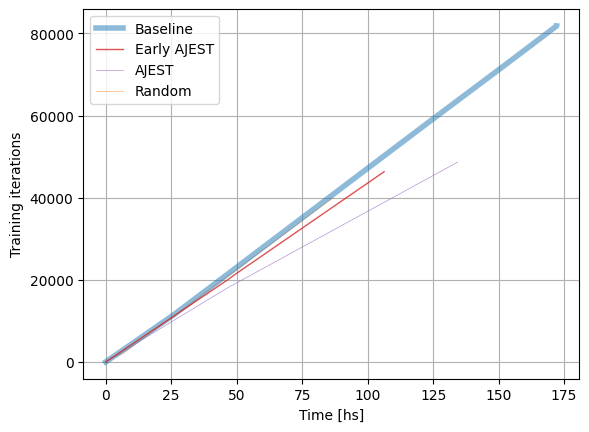

In [488]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(speed_curves[s]["time"], speed_curves[s]["epoch"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Time [hs]")
plt.ylabel("Training iterations")
# plt.xlim([-1, 48])
plt.grid()

In [489]:
speed_results = {}
for s in series:
    speed_curves[s]["epoch"].sort()
    speed_curves[s]["time"].sort()
    speed_results[s] = np.mean( np.diff(speed_curves[s]["epoch"]) / np.diff(speed_curves[s]["time"]) ) # Epochs/hs

In [490]:
speed_results

{'Baseline': np.float64(1197.1543213862515),
 'Early AJEST': np.float64(1834.224024010163),
 'AJEST': np.float64(1459.6085352010514),
 'Random': np.float64(1174.4007761006335)}

In [491]:
for s in series:
    print(60*60 / speed_results[s]) # sec/epoch

3.007131107233828
1.962682830927774
2.466414735992294
3.0653930696070306


## Epoch vs Images Seen

In [ ]:
# Load CSV data as Pandas dataframe
filepath = os.path.join(dir_results, "Epoch_vs_Nimg.csv")
pandas_data = pd.read_csv(filepath)

In [463]:
# Filter columns
for c in pandas_data.columns:
    condition = any([st in c for st in ["MIN", "MAX", "step"]])
    if condition: del pandas_data[c]

pandas_data = pandas_data.rename(columns={"Group: 06_CorrectEMA_AJEST_00 - Epoch":"AJEST Epoch",
                                          "Group: 06_CorrectEMA_Early_AJEST_00 - Epoch":"Early AJEST Epoch",
                                          "Group: 06_CorrectEMA_Random_00 - Epoch":"Random Epoch",
                                          "Group: 04_Tiny_LR_Baseline_04 - Epoch":"Baseline Epoch",
                                          "Seen images [kimg]":"Seen Images"})

In [464]:
speed_curves = {}
for s in series:
    speed_curves[s] = {}
    speed_curves[s]["nimg"], speed_curves[s]["epoch"] = pandas_data[["Seen Images",s+" Epoch"]][pd.notna(pandas_data[s+" Epoch"])].to_numpy().T
    # speed_curves[s]["nimg"] = speed_curves[s]["nimg"]/1e3/60/60

In [465]:
last_index = int( (speed_curves["Random"]["epoch"] >= 40000).argmax() )
for k, v in speed_curves["Random"].items():
    speed_curves["Random"][k] = v[:last_index]

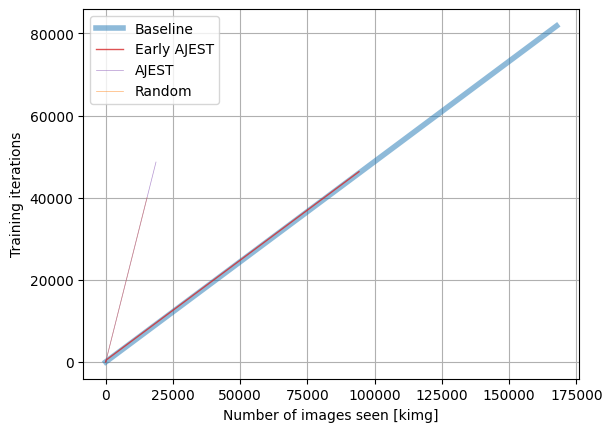

In [469]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(speed_curves[s]["nimg"], speed_curves[s]["epoch"], label=s, **plt_kwargs[s])
plt.legend()
plt.xlabel("Number of images seen [kimg]")
plt.ylabel("Training iterations")
# plt.xlim([-1, 48])
plt.grid()

In [470]:
np.mean( np.diff(speed_curves[s]["epoch"]) / np.diff(speed_curves[s]["nimg"]) ) # Epochs/kimg

np.float64(2.603777205624097)

# W&B Validation FID Plots' Data

## FID [EMA=0.05]

### Get data

In [345]:
ema = 0.05
guidance_weight = 1
metric = "fid"

In [346]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

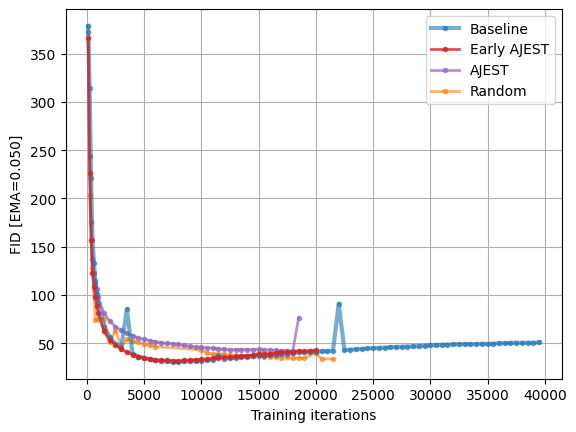

In [347]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [348]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [349]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050]__MAX
12,3500,85.070218,41.1484,216.200562


In [350]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 41.1484

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [351]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050]__MAX
49,22000,90.994601,40.434363,234.264574


In [352]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 40.434363

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [353]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050]__MAX
42,18500,76.410292,41.46697,212.463479


In [354]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 41.46697

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [355]:
fix_series = "Random"
fix_epoch = 2000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MAX
9,2000,50.900647,33.810501,67.990793


In [356]:
fix_series = "Random"
fix_epoch = 2000
fix_value = 67.990793

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [357]:
fix_series = "Random"
fix_epoch = 3000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MAX
11,3000,46.354974,33.814844,58.895105


In [358]:
fix_series = "Random"
fix_epoch = 3000
fix_value = 58.895105

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [359]:
fix_series = "Random"
fix_epoch = 1000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MAX
7,1000,75.308295,40.323484,92.800701


In [360]:
fix_series = "Random"
fix_epoch = 1000
fix_value = 92.800701

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [361]:
fix_series = "Random"
fix_epoch = 20000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MAX
45,20000,39.851484,34.312233,43.940186


In [362]:
fix_series = "Random"
fix_epoch = 20000
fix_value = 34.312233

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [365]:
fix_series = "Random"
fix_epoch = 750

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050]__MAX
5,750,73.678888,40.574324,106.783452


In [366]:
fix_series = "Random"
fix_epoch = 750
fix_value = 106.783452

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

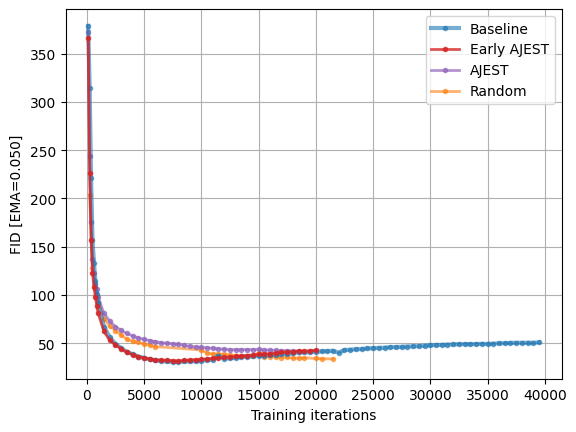

In [367]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Plot vs nimg

In [499]:
series_selection_kwargs = {}
for s in series:

    state = utils.get_final_state(series_path[s])
    state_selection_keys = ["change_epoch", "change_nimg"]
    selection_kwargs = {k:state[k] for k in state_selection_keys}

    params = utils.get_training_params(series_path[s])
    selection_params = infer_selection_params(params)
    selection_kwargs.update( selection_params )
    
    series_selection_kwargs[s] = selection_kwargs

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/hdd/vale/models/SCID/Images/06_CorrectEMA/Early AJEST/00'

## FID [EMA=0.10]

### Get data

In [322]:
ema = 0.1
guidance_weight = 1
metric = "fid"

In [323]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

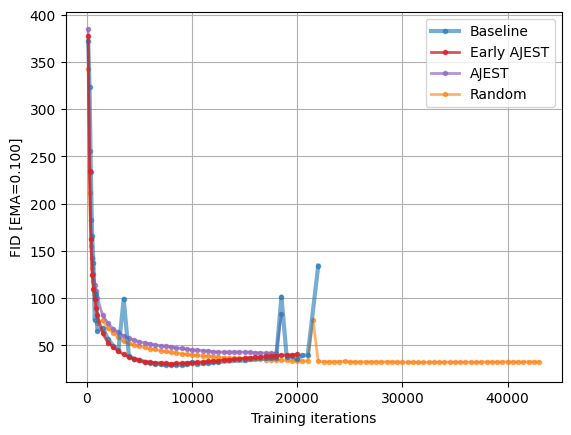

In [324]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [325]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [326]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MAX
12,3500,99.293588,41.1484,215.583965


In [327]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 41.1484

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [328]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MAX
42,18500,101.779098,37.682652,231.178501


In [329]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 37.682652

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [330]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MAX
49,22000,134.551728,40.434363,228.669093


In [331]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 40.434363

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [332]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100],Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100]__MIN,Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100]__MAX
42,18500,83.489546,41.46697,209.493436


In [333]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 41.46697

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [334]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100],Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100]__MAX
48,21500,76.709652,32.79995,207.423866


In [335]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 32.79995

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [339]:
fix_series = "Baseline"
fix_epoch = 750

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MAX
5,750,77.003536,35.429256,118.577817


In [340]:
fix_series = "Baseline"
fix_epoch = 750
fix_value = 118.577817

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [342]:
fix_series = "Baseline"
fix_epoch = 1000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100]__MAX
7,1000,65.45887,35.90939,95.008349


In [343]:
fix_series = "Baseline"
fix_epoch = 1000
fix_value = 95.008349

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

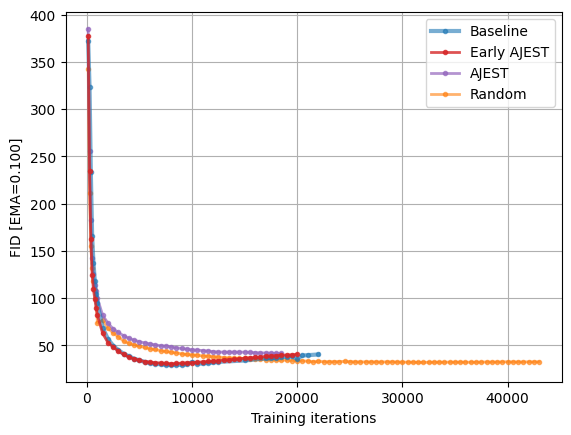

In [344]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## FD-DINOv2 [EMA=0.05]

### Get data

In [368]:
ema = 0.05
guidance_weight = 1
metric = "fd"

In [369]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

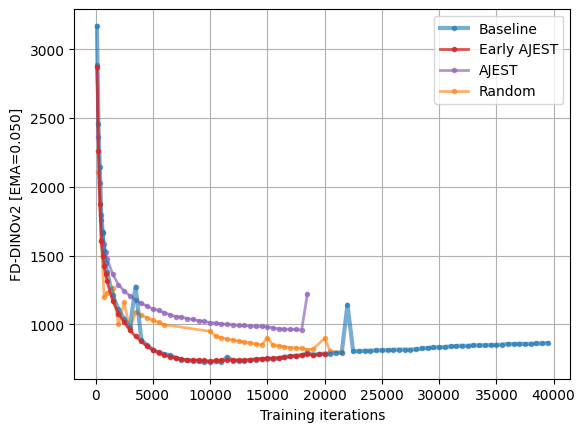

In [370]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [371]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [372]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050]__MAX
49,22000,1143.057046,774.061316,2154.144789


In [373]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 774.061316	

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [374]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050]__MAX
12,3500,1274.725636,926.937766,2314.553555


In [375]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 926.937766

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [376]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
42,18500,1221.772109,950.494877,2279.567958


In [377]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 950.494877	

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [381]:
fix_series = "Random"
fix_epoch = 750

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
5,750,1199.135077,924.631839,1473.638315


In [382]:
fix_series = "Random"
fix_epoch = 750
fix_value = 1473.638315

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [393]:
fix_series = "Random"
fix_epoch = 1000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
7,1000,1227.812557,915.252304,1384.092684


In [385]:
fix_series = "Random"
fix_epoch = 1000
fix_value = 1384.092684

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [387]:
fix_series = "Random"
fix_epoch = 2000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
9,2000,999.603384,798.383784,1200.822984


In [388]:
fix_series = "Random"
fix_epoch = 2000
fix_value = 1200.822984

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [390]:
fix_series = "Random"
fix_epoch = 3000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
11,3000,960.978946,799.099049,1122.858842


In [391]:
fix_series = "Random"
fix_epoch = 3000
fix_value = 1122.858842

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [395]:
fix_series = "Random"
fix_epoch = 15000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
35,15000,901.118414,846.693883,971.187033


In [396]:
fix_series = "Random"
fix_epoch = 15000
fix_value = 846.693883

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [398]:
fix_series = "Random"
fix_epoch = 10000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
25,10000,949.104723,915.252304,981.86621


In [399]:
fix_series = "Random"
fix_epoch = 10000
fix_value = 915.252304

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [401]:
fix_series = "Random"
fix_epoch = 20000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050]__MAX
45,20000,898.565637,809.161742,962.237029


In [402]:
fix_series = "Random"
fix_epoch = 20000
fix_value = 809.161742

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

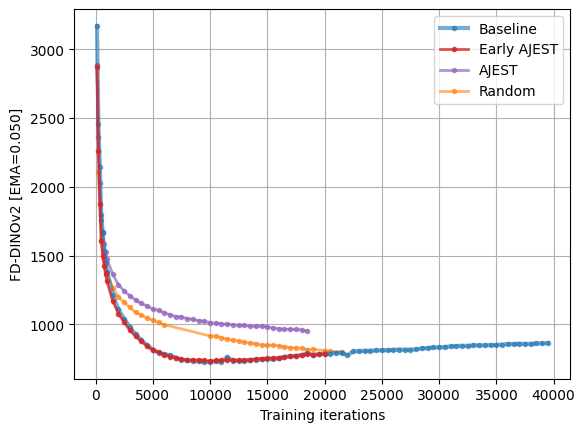

In [403]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## FD-DINOv2 [EMA=0.1]

### Get data

In [404]:
ema = 0.10
guidance_weight = 1
metric = "fd"

In [405]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

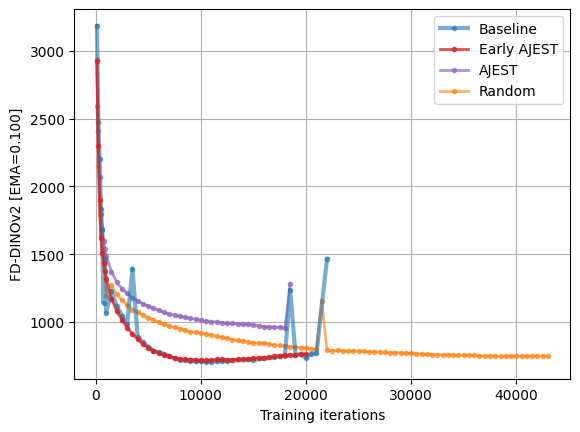

In [406]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [407]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [408]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
12,3500,1392.962824,930.473455,2317.941562


In [409]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 930.473455

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [410]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
42,18500,1234.785269,755.966097,2183.585601


In [411]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 755.966097

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [412]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
49,22000,1466.05164,774.061316,2158.041965


In [413]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 774.061316

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [414]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100]__MAX
48,21500,1156.40729,790.083183,2246.363745


In [415]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 790.083183

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [416]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100],Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100]__MAX
42,18500,1281.802645,950.494877,2275.153196


In [417]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 950.494877

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [421]:
fix_series = "Baseline"
fix_epoch = 750

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
5,750,1142.225354,727.64966,1556.801049


In [422]:
fix_series = "Baseline"
fix_epoch = 750
fix_value = 1556.801049

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [424]:
fix_series = "Baseline"
fix_epoch = 1000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
7,1000,1067.664777,733.511019,1401.818535


In [425]:
fix_series = "Baseline"
fix_epoch = 1000
fix_value = 1401.818535

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [427]:
fix_series = "Baseline"
fix_epoch = 20000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100]__MAX
45,20000,733.085944,714.54119,761.160132


In [428]:
fix_series = "Baseline"
fix_epoch = 20000
fix_value = 761.160132

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [430]:
fix_series = "Random"
fix_epoch = 1000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100],Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100]__MIN,Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100]__MAX
7,1000,1191.484155,790.083183,1400.276598


In [431]:
fix_series = "Random"
fix_epoch = 1000
fix_value = 1400.276598

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

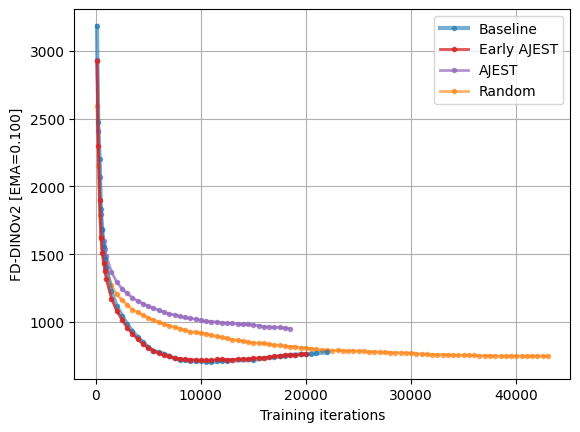

In [432]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## FID [EMA=0.05, Guidance=1.7]

### Get data

In [87]:
ema = 0.05
guidance_weight = 1.7
metric = "fid"

In [88]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

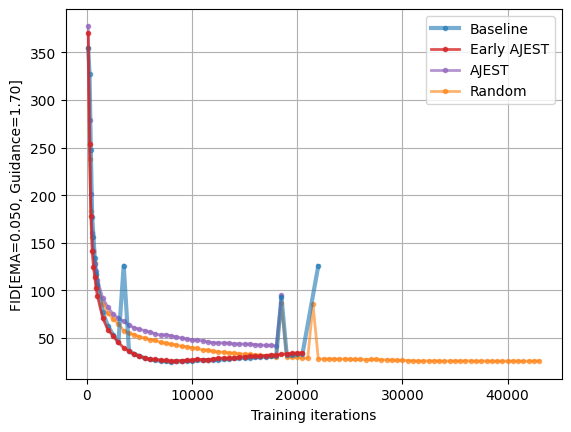

In [89]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [90]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [91]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
12,3500,126.005378,40.821738,211.189912


In [92]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 40.821738

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [93]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
42,18500,92.950956,32.219437,214.413995


In [94]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 32.219437

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [95]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
49,22000,125.586839,34.282979,216.890699


In [96]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 34.282979

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [97]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
42,18500,94.986787,41.750321,201.459718


In [98]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 41.750321

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [99]:
fix_series = "Random"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
42,18500,86.340084,30.350701,198.318849


In [100]:
fix_series = "Random"
fix_epoch = 18500
fix_value = 30.350701

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [101]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.050, Guidance=1.70]__MAX"
48,21500,85.714402,28.561061,200.021083


In [102]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 28.561061

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

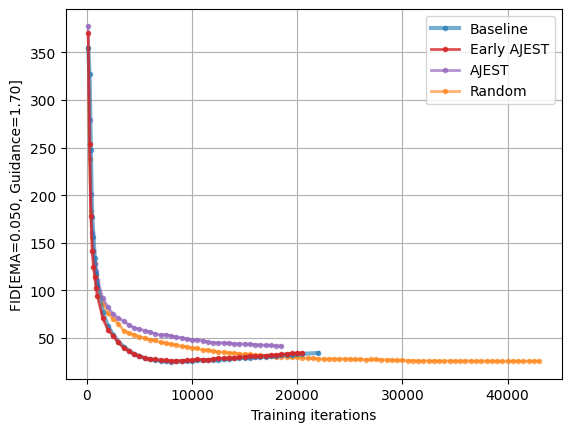

In [103]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

## FD-DINOv2 [EMA=0.05, Guidance=1.7]

### Get data

In [104]:
ema = 0.05
guidance_weight = 1.7
metric = "fd"

In [105]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

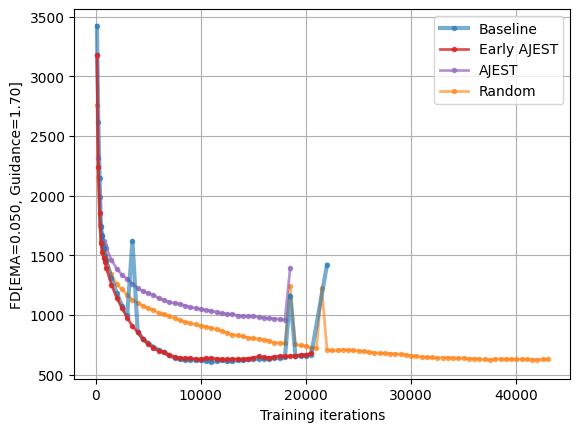

In [106]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [107]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [108]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
12,3500,1620.712438,926.901472,2314.614205


In [109]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 926.901472

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [110]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
42,18500,1162.380809,654.480615,2178.181198


In [111]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 654.480615

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [112]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
49,22000,1420.035715,676.845382,2163.226048


In [113]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 676.845382

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [114]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
42,18500,1392.704379,959.068426,2259.976283


In [115]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 959.068426

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [116]:
fix_series = "Random"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
42,18500,1239.799373,753.168739,2213.060642


In [117]:
fix_series = "Random"
fix_epoch = 18500
fix_value = 753.168739

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [118]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.050, Guidance=1.70]__MAX"
48,21500,1222.251208,717.144535,2232.464553


In [119]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 717.144535

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

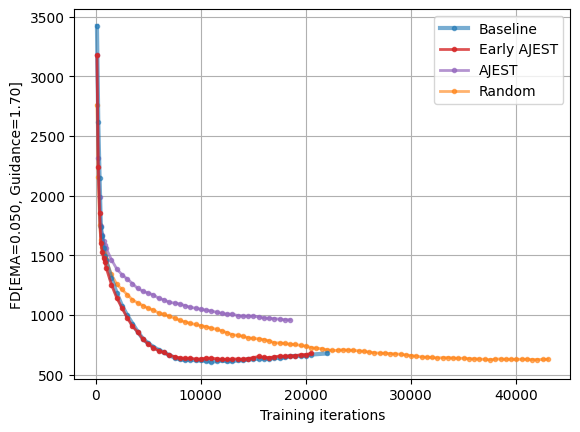

In [120]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

## FID [EMA=0.10, Guidance=2.2]

### Get data

In [121]:
ema = 0.10
guidance_weight = 2.2
metric = "fid"

In [122]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

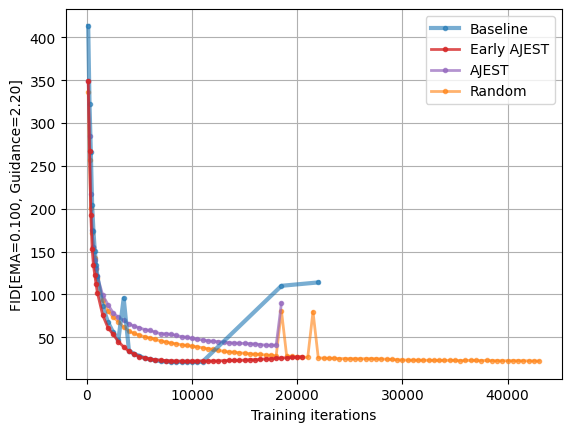

In [123]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [124]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [125]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
12,3500,95.485426,40.057715,206.340847


In [126]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 40.057715

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [127]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
42,18500,110.046819,24.390567,195.703071


In [128]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 24.390567

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [129]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
49,22000,114.000002,26.859634,201.140369


In [130]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 26.859634

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [131]:
fix_series = "Random"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
42,18500,80.811616,28.088212,186.258424


In [132]:
fix_series = "Random"
fix_epoch = 18500
fix_value = 28.088212

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [133]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
48,21500,79.838135,26.403115,186.708176


In [134]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 26.403115

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [135]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_AJEST_00 - Validation FID [EMA=0.100, Guidance=2.20]__MAX"
42,18500,89.925916,40.289357,189.199035


In [136]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 40.289357

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

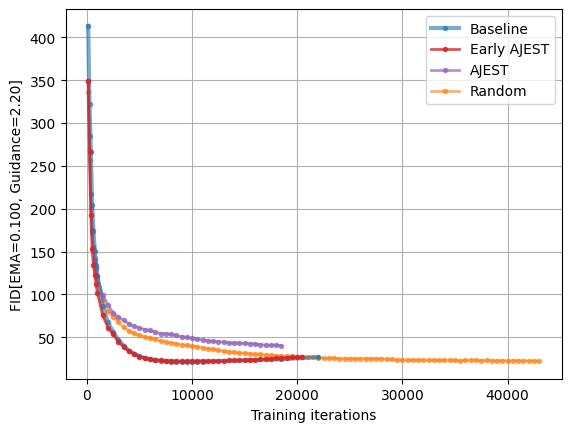

In [137]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

## FD-DINOv2 [EMA=0.10, Guidance=2.2]

### Get data

In [138]:
ema = 0.10
guidance_weight = 2.2
metric = "fd"

In [139]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

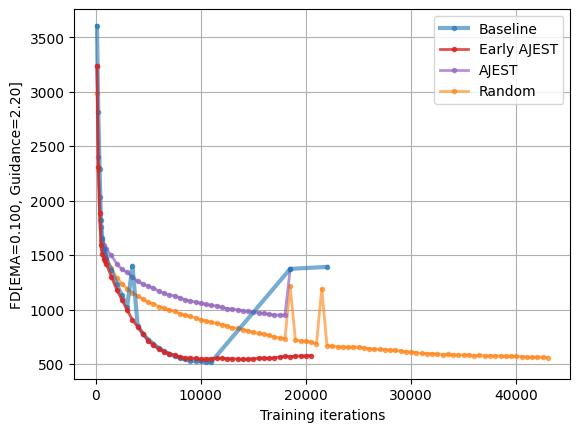

In [140]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [141]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [142]:
fix_series = "Baseline"
fix_epoch = 3500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
12,3500,1401.419785,940.436174,2323.387007


In [143]:
fix_series = "Baseline"
fix_epoch = 3500
fix_value = 940.436174

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [144]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
42,18500,1373.488541,546.835463,2200.141618


In [145]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 546.835463

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [146]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
49,22000,1390.960738,570.761982,2211.159495


In [147]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 570.761982

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [148]:
fix_series = "Random"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
42,18500,1212.033771,720.264936,2195.57144


In [149]:
fix_series = "Random"
fix_epoch = 18500
fix_value = 720.264936

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [150]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_Random_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
48,21500,1190.834507,680.936648,2210.630224


In [151]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 680.936648	

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [152]:
fix_series = "AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]","Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MIN","Group: 06_CorrectEMA_AJEST_00 - Validation FD-DINOv2 [EMA=0.100, Guidance=2.20]__MAX"
42,18500,1374.851398,939.907114,2244.739967


In [153]:
fix_series = "AJEST"
fix_epoch = 18500
fix_value = 939.907114

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

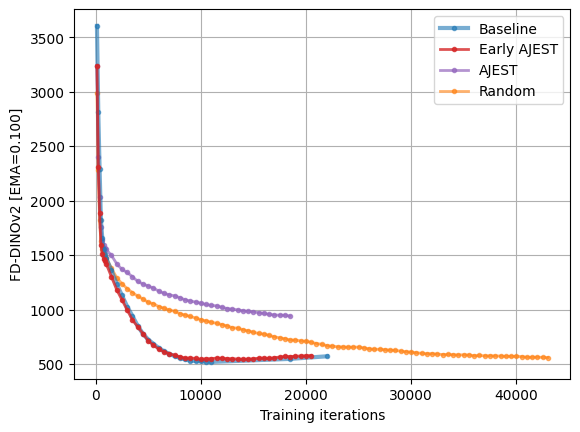

In [154]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Check data

In [155]:
# check_metric = "fid"
# check_series = "AJEST"

# for i, check_epoch in enumerate(results_val[check_metric][f"ema=0.050"][check_series]["epoch"]):
#     j = (results_val[check_metric][f"ema=0.100"][check_series]["epoch"] == check_epoch).argmin()
#     print(results_val[check_metric][f"ema=0.050"][check_series]["data"][i] == results_val[check_metric][f"ema=0.100"][check_series]["data"][j])

In [156]:
# check_metric = "fd"
# check_series = "AJEST"

# for i, check_epoch in enumerate(results_val[check_metric][f"ema=0.050"][check_series]["epoch"]):
#     j = (results_val[check_metric][f"ema=0.100"][check_series]["epoch"] == check_epoch).argmin()
#     print(results_val[check_metric][f"ema=0.050"][check_series]["data"][i] == results_val[check_metric][f"ema=0.100"][check_series]["data"][j])

In [157]:
# check_metric = "fd"
# check_series = "Early AJEST"

# results_val[check_metric][f"ema=0.050"][check_series]["data"] == results_val[check_metric][f"ema=0.100"][check_series]["data"]

# W&B Validation Classification Plots' Data

## Top-1 [EMA=0.05]

### Get data

In [158]:
ema = 0.05
guidance_weight = 1
metric = "top1"

In [159]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

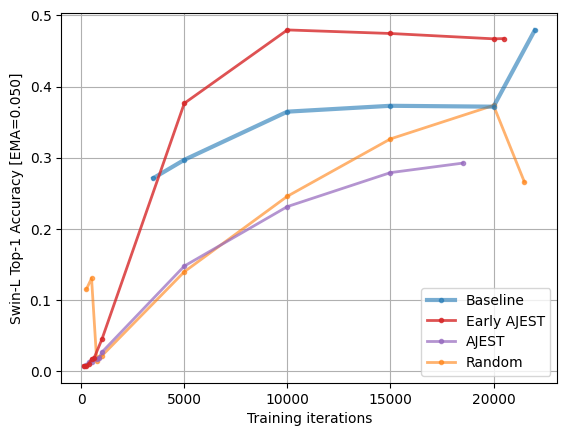

In [160]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [161]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [162]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

##### Mmhmmmm

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MAX
16,22000,0.479,0.479,0.479


In [163]:
fix_series = "Random"
fix_epoch = 250

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MAX
1,250,0.1155,0.01,0.3265


In [164]:
fix_series = "Random"
fix_epoch = 250
fix_value = 0.01	

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [165]:
fix_series = "Random"
fix_epoch = 500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MAX
3,500,0.130833,0.0095,0.3735


In [166]:
fix_series = "Random"
fix_epoch = 500
fix_value = 0.0095

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [167]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-1 Accuracy [EMA=0.050]__MAX
15,21500,0.266,0.14,0.392


In [168]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 0.392

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

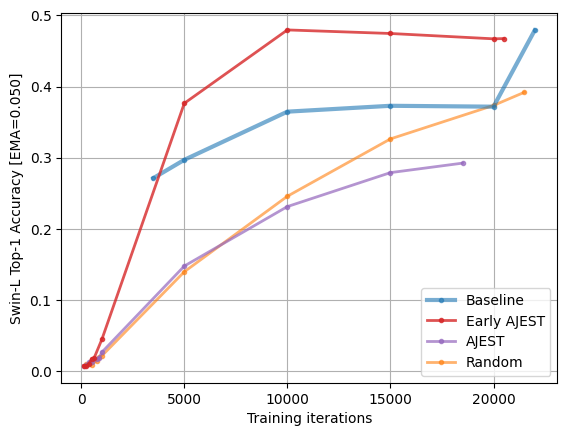

In [169]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-1 [EMA=0.10]

### Get data

In [170]:
ema = 0.10
guidance_weight = 1
metric = "top1"

In [171]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

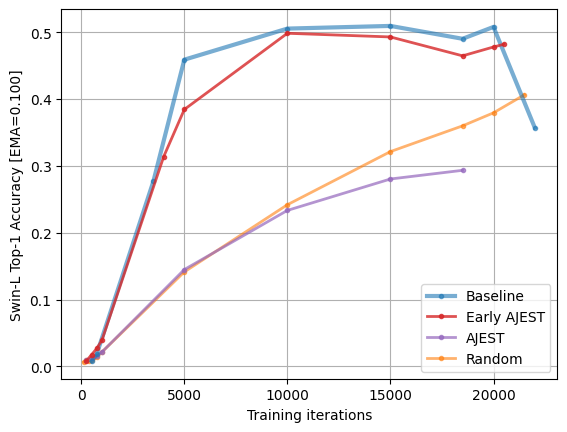

In [172]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [173]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [174]:
fix_series = "Early AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-1 Accuracy [EMA=0.100],Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MIN,Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MAX
12,18500,0.46475,0.453,0.4765


In [175]:
fix_series = "Early AJEST"
fix_epoch = 18500
fix_value = 0.4765

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [176]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MAX
12,18500,0.49025,0.477,0.5035


In [177]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 0.5035

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [178]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100]__MAX
16,22000,0.3575,0.034,0.5195


In [179]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 0.5195

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

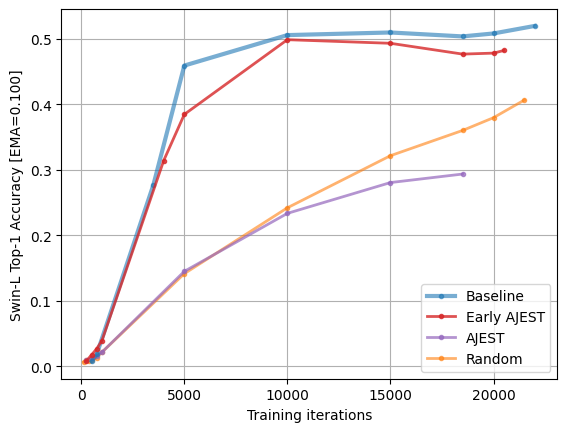

In [180]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-1 [EMA=0.10, Guidance=2.2]

### Get data

In [191]:
ema = 0.10
guidance_weight = 2.2
metric = "top1"

In [192]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

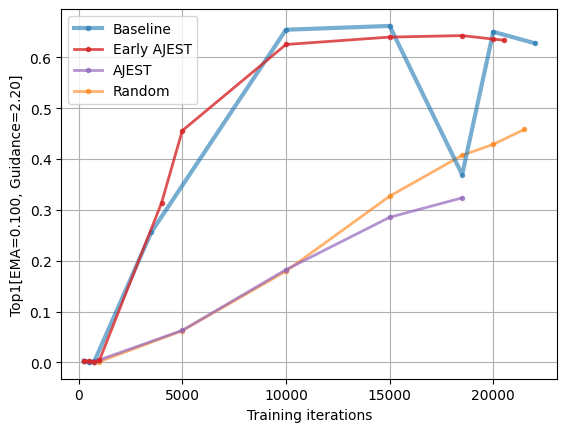

In [193]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [194]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [195]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-1 Accuracy [EMA=0.100, Guidance=2.20]__MAX"
9,18500,0.3695,0.0025,0.653


In [196]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 0.653

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

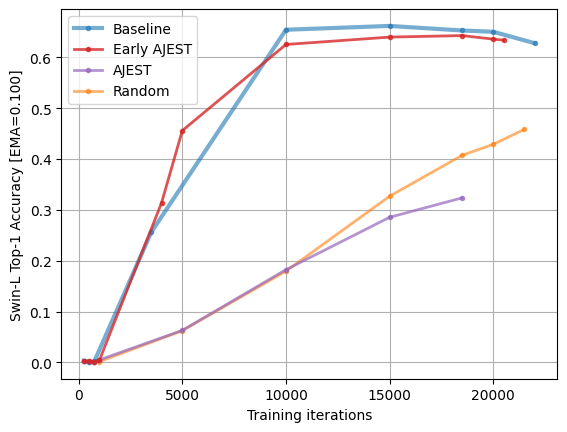

In [197]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-1 [EMA=0.05, Guidance=1.7]

### Get data

In [198]:
ema = 0.05
guidance_weight = 1.7
metric = "top1"

In [199]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

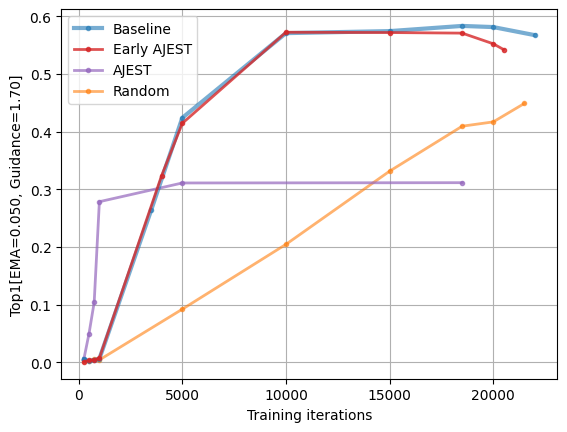

In [200]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

## Top-5 [EMA=0.05]

### Get data

In [215]:
ema = 0.05
guidance_weight = 1
metric = "top5"

In [216]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

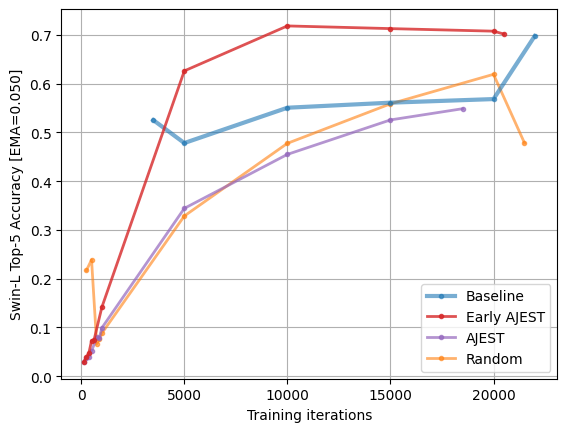

In [217]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [218]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [219]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

##### Mmhmmmm

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.050],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MAX
16,22000,0.6975,0.6975,0.6975


In [220]:
fix_series = "Random"
fix_epoch = 250

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MAX
1,250,0.216833,0.046,0.5585


In [221]:
fix_series = "Random"
fix_epoch = 250
fix_value = 0.046	

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [222]:
fix_series = "Random"
fix_epoch = 500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MAX
3,500,0.238667,0.0485,0.619


In [223]:
fix_series = "Random"
fix_epoch = 500
fix_value = 0.0485

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [224]:
fix_series = "Random"
fix_epoch = 21500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050],Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_Random_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MAX
15,21500,0.4785,0.3285,0.6285


In [227]:
fix_series = "Random"
fix_epoch = 21500
fix_value = 0.6285

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

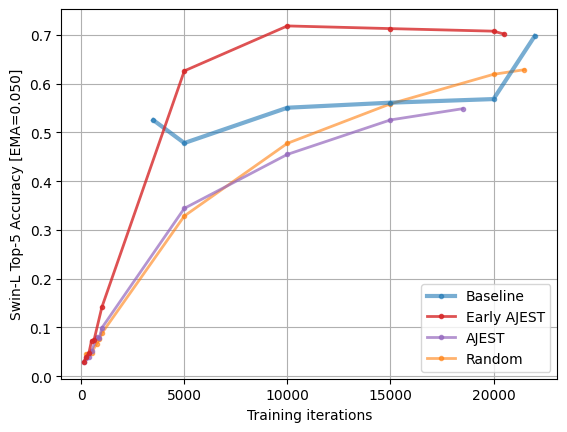

In [228]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-5 [EMA=0.10]

### Get data

In [201]:
ema = 0.10
guidance_weight = 1
metric = "top5"

In [202]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

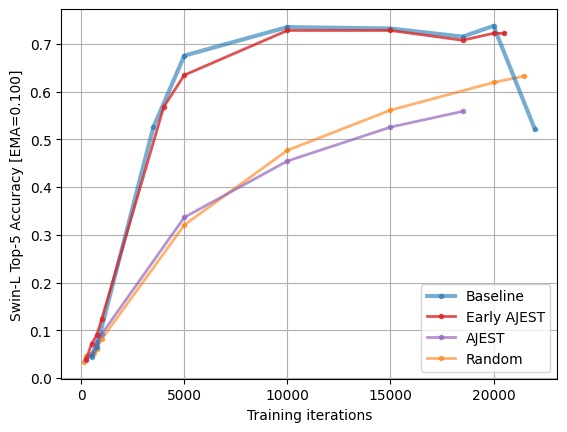

In [203]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [204]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [205]:
fix_series = "Baseline"
fix_epoch = 22000

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MAX
16,22000,0.521667,0.1165,0.725


In [206]:
fix_series = "Baseline"
fix_epoch = 22000
fix_value = 0.725

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [208]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100],Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MIN,Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MAX
12,18500,0.715,0.703,0.727


In [209]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 0.727

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

In [212]:
fix_series = "Early AJEST"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.100],Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MIN,Group: 06_CorrectEMA_Early_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.100]__MAX
12,18500,0.7075,0.696,0.719


In [213]:
fix_series = "Early AJEST"
fix_epoch = 18500
fix_value = 0.719

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

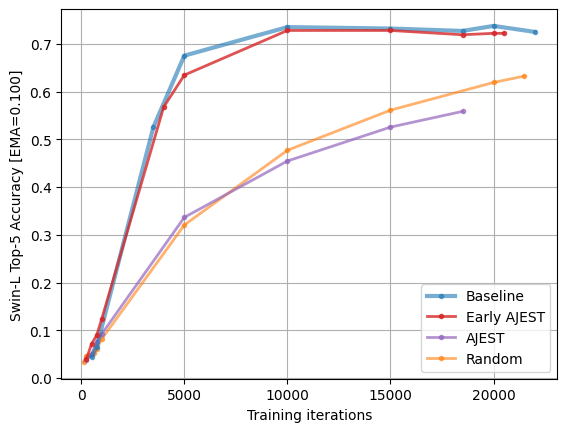

In [214]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-5 [EMA=0.10, Guidance=2.2]

### Get data

In [232]:
ema = 0.10
guidance_weight = 2.2
metric = "top5"

In [233]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

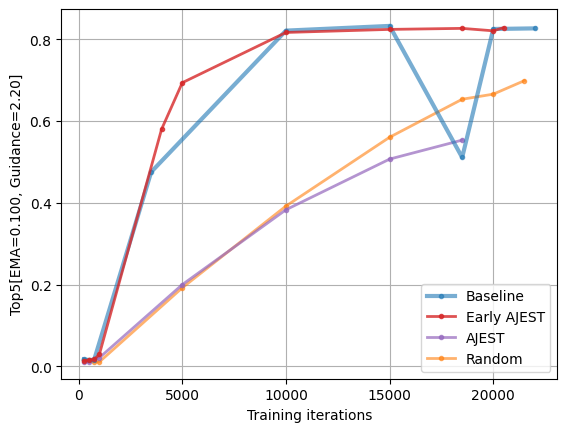

In [234]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(get_validation_y_label(metric, ema, guidance_weight))
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [235]:
filepath = get_validation_filepath(metric, ema, guidance_weight=guidance_weight)
pandas_data = pd.read_csv(filepath)

In [236]:
fix_series = "Baseline"
fix_epoch = 18500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

,Validation Epoch,"Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100, Guidance=2.20]","Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100, Guidance=2.20]__MIN","Group: 04_Tiny_LR_Baseline_04 - Validation Swin-L Top-5 Accuracy [EMA=0.100, Guidance=2.20]__MAX"
9,18500,0.511,0.0195,0.822


In [237]:
fix_series = "Baseline"
fix_epoch = 18500
fix_value = 0.822

these_results[fix_series]["data"][these_results[fix_series]["epoch"]==fix_epoch] = fix_value

### Plot

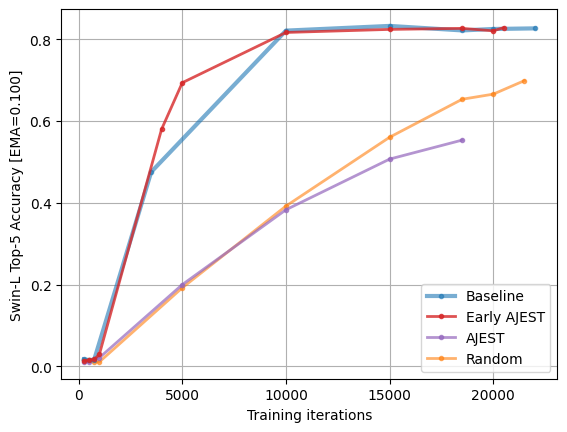

In [238]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

## Top-5 [EMA=0.05, Guidance=1.7]

### Get data

In [249]:
ema = 0.05
guidance_weight = 1.7
metric = "top5"

In [250]:
results_val = load_validation_curves_set(metric, ema, guidance_weight=guidance_weight, results_dict=results_val)
these_results = results_val[metric][f"ema={ema:.3f}"][f"guidance={guidance_weight:.2f}"]
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

### Plot

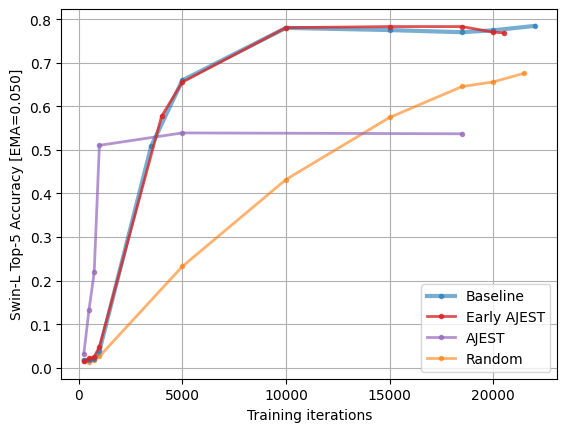

In [251]:
fig, ax = plt.subplots()
for s in series:
    plt.plot(these_results[s]["epoch"], these_results[s]["data"], ".-", label=s, **plt_kwargs_val[s])
plt.legend()
plt.xlabel("Training iterations")
plt.ylabel(metrics_names[metric] + f" [EMA={ema:.3f}]")
# plt.xlim([-800, 18500])
plt.grid()

### Inspect and fix data

In [252]:
filepath = get_validation_filepath(metric, ema)
pandas_data = pd.read_csv(filepath)

In [ ]:
fix_series = "AJEST"
fix_epoch = 500

filtered_data = pandas_data.filter(regex=regex_series[fix_series])
filtered_data[filtered_data["Validation Epoch"]==fix_epoch]

### MHMMMHMHM

,Validation Epoch,Group: 06_CorrectEMA_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050],Group: 06_CorrectEMA_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MIN,Group: 06_CorrectEMA_AJEST_00 - Validation Swin-L Top-5 Accuracy [EMA=0.050]__MAX
3,500,0.051414,0.048828,0.054


## Save validation results

In [433]:
results_val

{'fid': {'ema=0.050': {'guidance=1.00': {'Baseline': {'epoch': array([  125.,   250.,   375.,   500.,   625.,   750.,   875.,  1000.,
             1500.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
             5500.,  6000.,  6500.,  7000.,  7500.,  8000.,  8500.,  9000.,
             9500., 10000., 10500., 11000., 11500., 12000., 12500., 13000.,
            13500., 14000., 14500., 15000., 15500., 16000., 16500., 17000.,
            17500., 18000., 18500., 19000., 19500., 20000., 20500., 21000.,
            21500., 22000., 22500., 23000., 23500., 24000., 24500., 25000.,
            25500., 26000., 26500., 27000., 27500., 28000., 28500., 29000.,
            29500., 30000., 30500., 31000., 31500., 32000., 32500., 33000.,
            33500., 34000., 34500., 35000., 35500., 36000., 36500., 37000.,
            37500., 38000., 38500., 39000., 39500.]),
     'data': array([378.62217048, 314.78035548, 220.83544391, 156.82682794,
            133.52314268, 114.78241305, 100.88596744

In [434]:
results_filepath = os.path.join(dir_results, "all_validation.json")

In [436]:
results_val_save = copy.deepcopy(results_val)
def convert_numpy_to_list_in_dict(dict_obj):
    for k in dict_obj.keys():
        if isinstance(dict_obj[k], dict):
            dict_obj[k] = convert_numpy_to_list_in_dict(dict_obj[k])
        elif isinstance(dict_obj[k], np.ndarray):
            if "epoch" in k.lower():
                list_obj = [int(value) for value in dict_obj[k]]
            else:
                list_obj = [float(value) for value in dict_obj[k]]
            dict_obj[k] = list_obj
    return dict_obj
results_val_save = convert_numpy_to_list_in_dict(results_val_save)


In [437]:
with open(os.path.join(results_filepath), 'wt') as f:
    json.dump(results_val_save, f, indent=2)